In [94]:
import numpy as np
import tensorflow as tf
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import random
seed = 42
np.random.seed = seed

In [6]:
import os
# import data from my google drive  
# os.listdir('/content/drive/MyDrive/ECSE_458/UltrasoundImages')

from google.colab import drive
drive.mount('/content/drive/')

path = "/content/drive/MyDrive/ECSE_458/UltrasoundImages/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# load the images and masks
train_images = []
train_masks = []

load_images = glob(path + 'images/*.png')
load_masks = glob(path + 'masks/*.png')

for f in load_images:
    train_images.append(Image.open(f))

for f in load_masks:
    train_masks.append(Image.open(f))

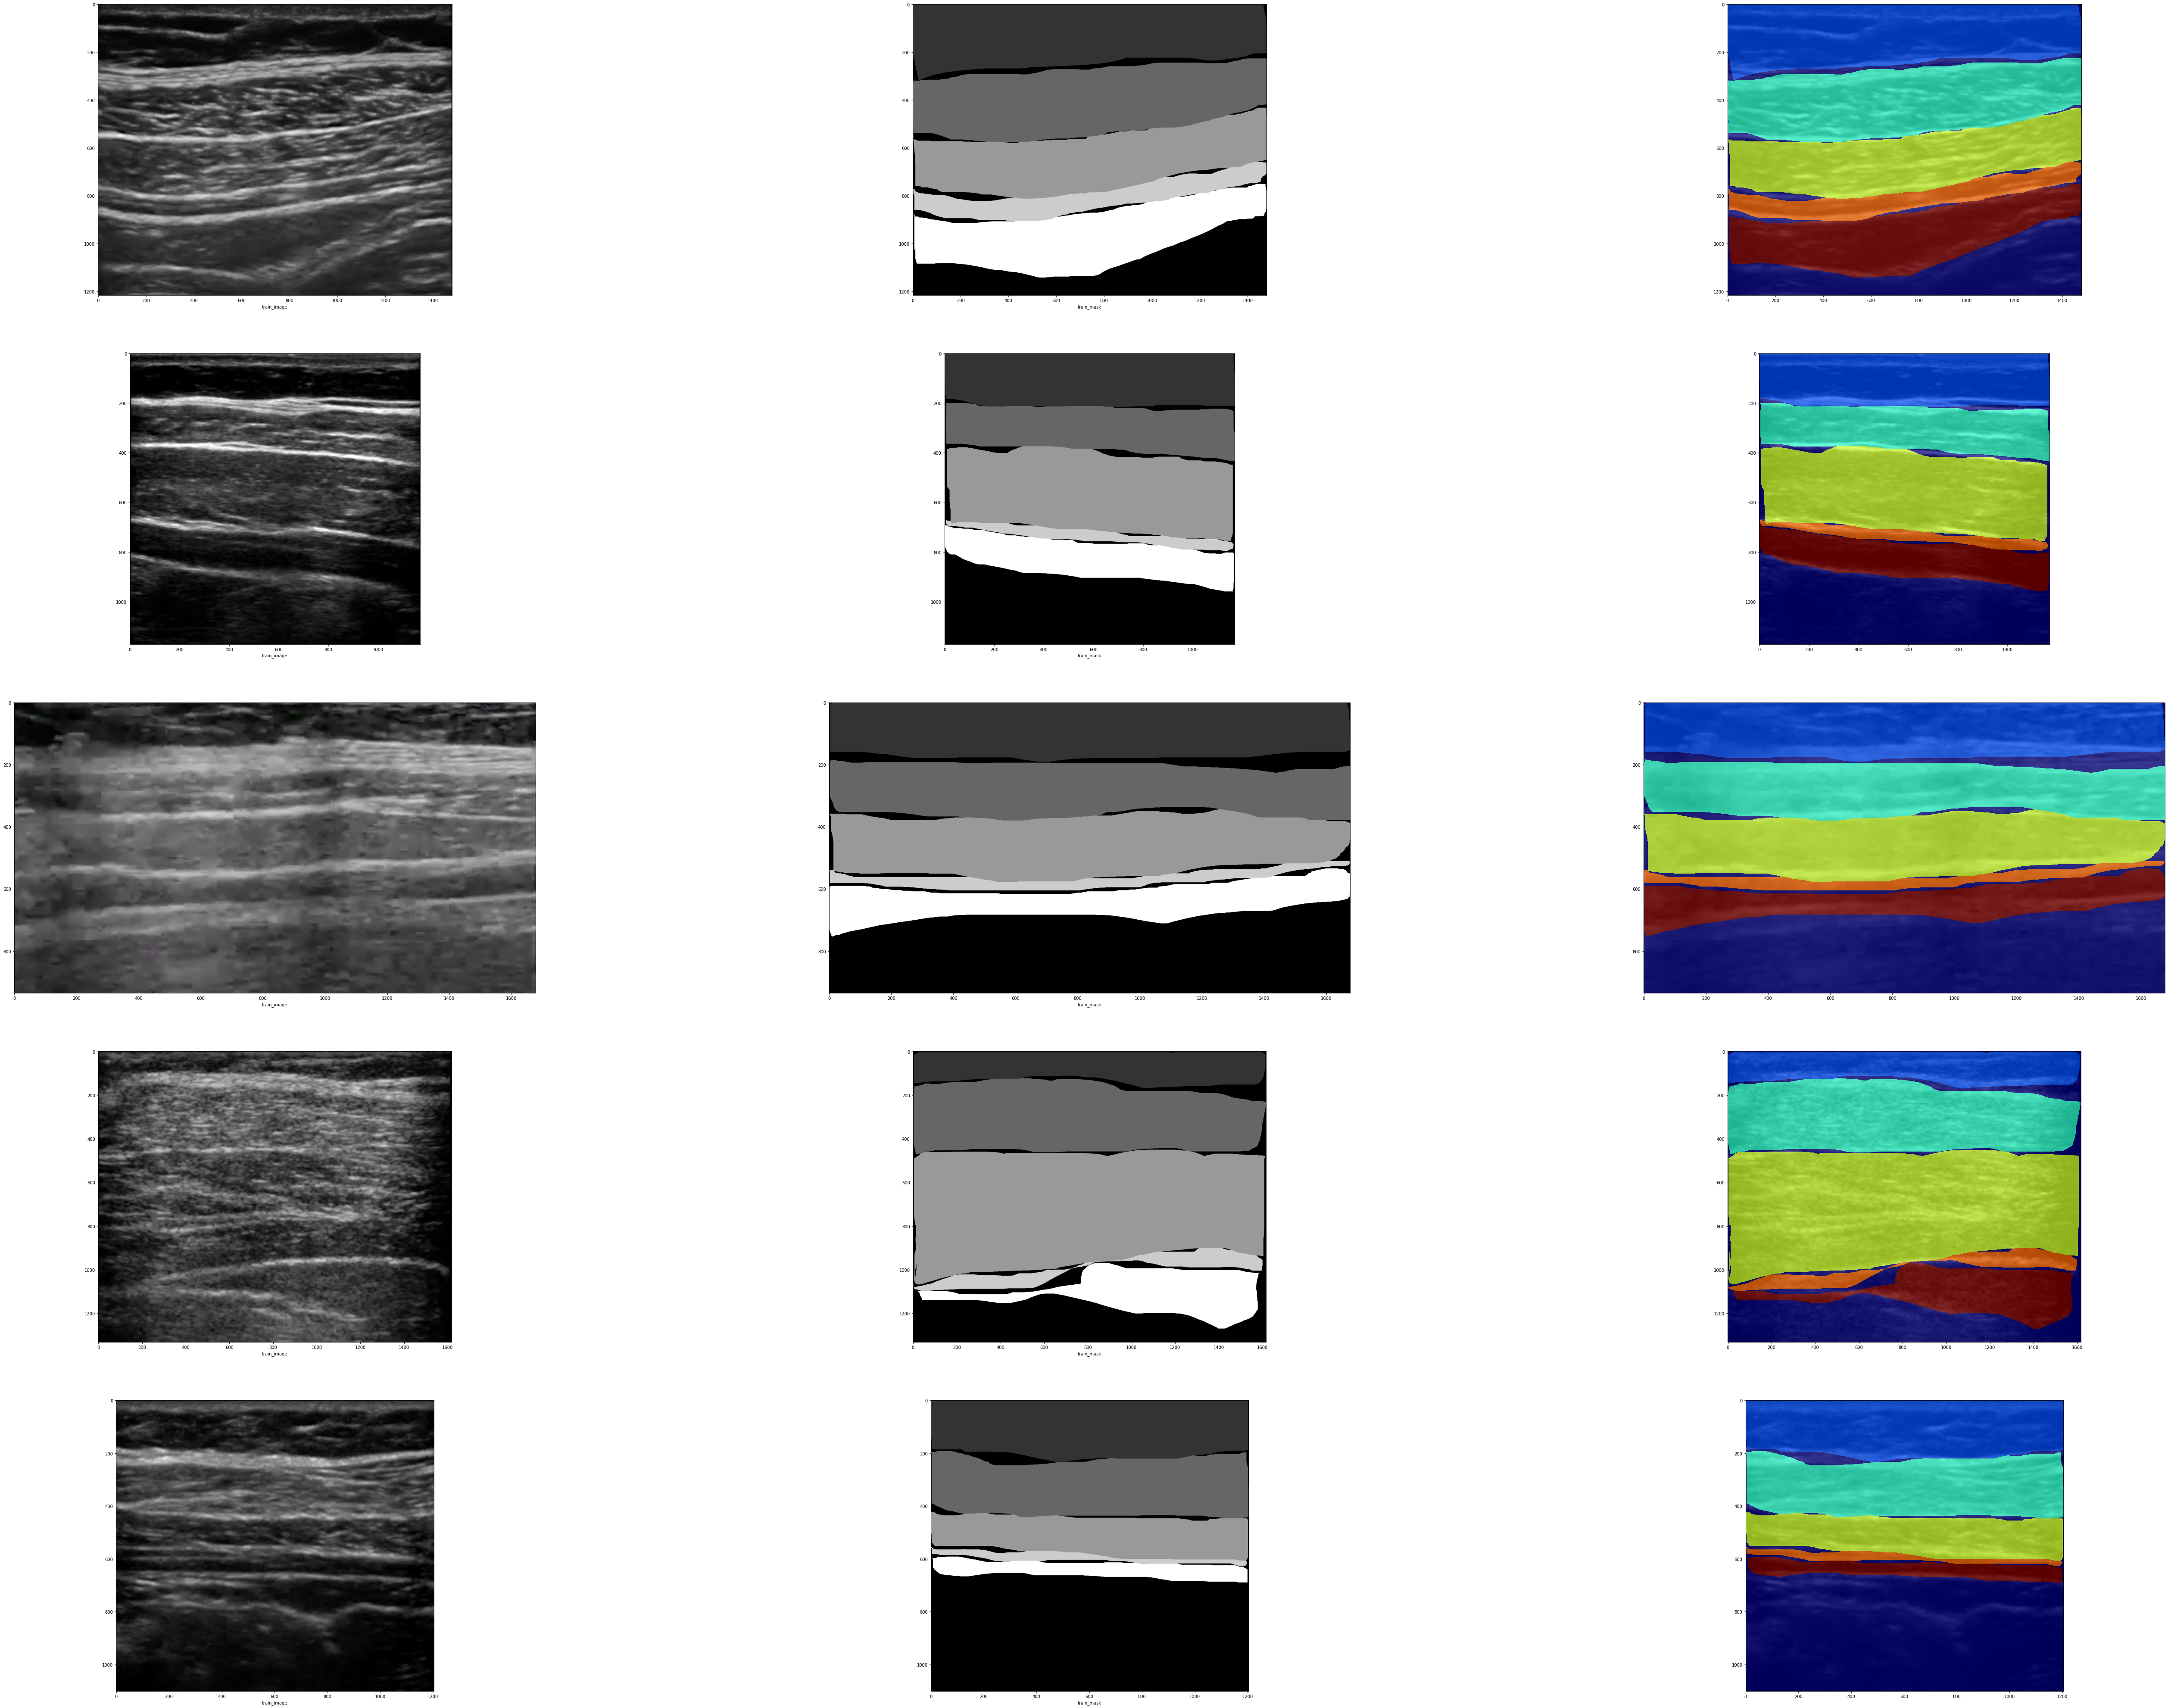

In [70]:
# Display the first 5 images and their masks of the corresponding subjects.

mask_05 = copy.deepcopy(train_masks[:5])

fig, ax = plt.subplots(5,3,figsize = (96,72))

for i in range (0,5):
  ax[i][0].imshow(train_images[i], cmap = 'gray')
  ax[i][1].imshow(mask_05[i], cmap = 'gray')
  ax[i][2].imshow(train_images[i], cmap = 'gray', interpolation = 'none')
  ax[i][2].imshow(mask_05[i], cmap = 'jet', interpolation = 'none', alpha = 0.7)

  ax[i][0].set(xlabel="train_image")
  ax[i][1].set(xlabel="train_mask")
  
plt.show()

## Image processing

In [111]:
# resizing the images
# train images
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

image_ids = glob(path + 'images/*.png')
mask_ids = glob(path + 'masks/*.png')

In [131]:
# resizing images (X_train)
X_train = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):

  img = imread(id_)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img

100%|██████████| 554/554 [02:42<00:00,  3.41it/s]


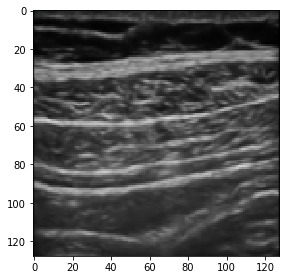

In [135]:
imshow(X_train[0])
plt.show()

In [117]:
# resizing masks (Y_train)
#Y_train = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_train = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):

  mask = imread(id_)
  mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
  #mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  #mask = np.maximum(mask, mask_)
  Y_train[n] = mask

100%|██████████| 554/554 [01:05<00:00,  8.42it/s]


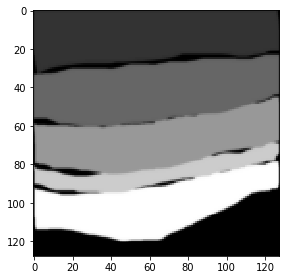

In [139]:
imshow(np.squeeze(Y_train[0]))
plt.show()

In [134]:
# resizing test images
test_ids = image_ids[:100]
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

  test = imread(id_)[:,:,:IMG_CHANNELS]
  test = resize(test, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = test

100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


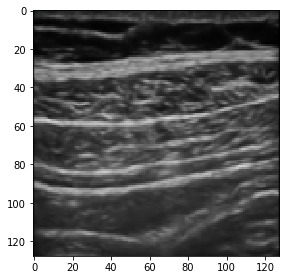

In [140]:
imshow(np.squeeze(X_test[0]))
plt.show()

## U-net model


In [90]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    #s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    return model

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

##Model Checkpointer, callbacks and fit

In [138]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/3
32/32 [==============================] - 79s 2s/step - loss: nan - accuracy: 0.2770 - val_loss: nan - val_accuracy: 0.2597
Epoch 2/3
32/32 [==============================] - 79s 2s/step - loss: nan - accuracy: 0.2770 - val_loss: nan - val_accuracy: 0.2597


### Virtualization of the results

4/4 [==============================] - 3s 737ms/step


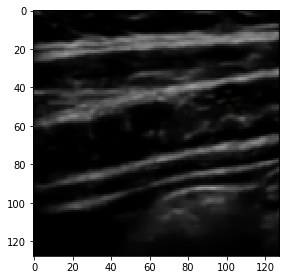

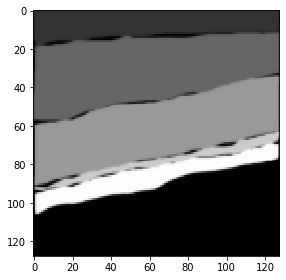

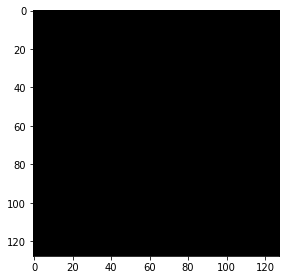

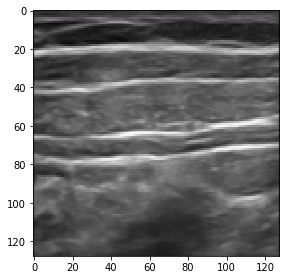

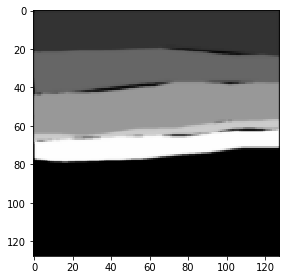

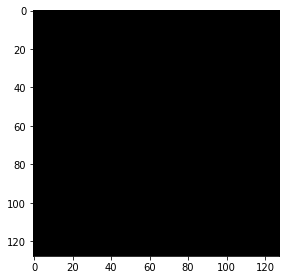

In [147]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()